### Sistema de Recomendação por Imagens

In [ ]:
!pip install faiss-cpu --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.neighbors import NearestNeighbors

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizar [0,1] e expandir canal (grayscale -> 1 canal)
x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.0

print("Formato do treino:", x_train.shape, "Formato do teste:", x_test.shape)

Formato do treino: (60000, 28, 28, 1) Formato do teste: (10000, 28, 28, 1)


In [ ]:
# Usar apenas uma parte do dataset
n_samples_train = 10000   # de 60k
n_samples_test = 2000     # de 10k

x_train_small = x_train[:n_samples_train]
y_train_small = y_train[:n_samples_train]
x_test_small = x_test[:n_samples_test]
y_test_small = y_test[:n_samples_test]

print("Novo tamanho treino:", x_train_small.shape)
print("Novo tamanho teste:", x_test_small.shape)

Novo tamanho treino: (10000, 28, 28, 1)
Novo tamanho teste: (2000, 28, 28, 1)


In [ ]:
x_train_rgb = np.repeat(x_train_small, 3, axis=-1)
x_test_rgb = np.repeat(x_test_small, 3, axis=-1)

datagen = ImageDataGenerator()

# Redimensionar para 224x224 ANTES de usar o generator
x_train_resized = tf.image.resize(x_train_rgb, (224, 224))
x_test_resized = tf.image.resize(x_test_rgb, (224, 224))

train_gen = datagen.flow(x_train_resized, batch_size=64, shuffle=False)
test_gen = datagen.flow(x_test_resized, batch_size=64, shuffle=False)

In [ ]:
base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")

# Extrair embeddings sem carregar tudo em RAM
train_features = base_model.predict(train_gen, verbose=1)
test_features = base_model.predict(test_gen, verbose=1)

print("Embeddings treino:", train_features.shape)
print("Embeddings teste:", test_features.shape)

/tmp/ipython-input-1121041528.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step
Embeddings treino: (10000, 1280)
Embeddings teste: (2000, 1280)


In [ ]:
nn = NearestNeighbors(n_neighbors=6, metric="cosine")
nn.fit(train_features)

NearestNeighbors(metric='cosine', n_neighbors=6)

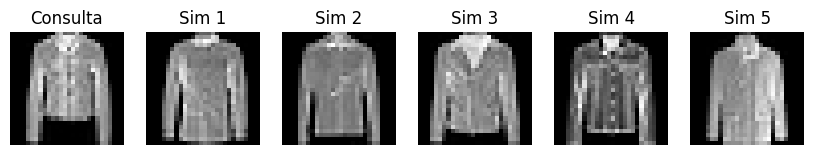

In [ ]:
def recomendar(idx):
    query_feat = test_features[idx].reshape(1, -1)
    distances, indices = nn.kneighbors(query_feat)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 7, 1)
    plt.imshow(x_test_small[idx].squeeze(), cmap="gray")
    plt.title("Consulta")
    plt.axis("off")

    for i, neighbor_idx in enumerate(indices[0][1:]):
        plt.subplot(1, 7, i+2)
        plt.imshow(x_train_small[neighbor_idx].squeeze(), cmap="gray")
        plt.title(f"Sim {i+1}")
        plt.axis("off")
    plt.show()

recomendar(10)